In [37]:
import pandas as pd
import numpy as np
import csv
import sqlite3
import re
import pickle


from sklearn.dummy import DummyClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc


from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.style.use('seaborn')

In [3]:
pkl_filename= '/Users/xzhou/github/project_files/lending_club/loan.pkl'

with open(pkl_filename, 'rb') as pklfile:
    df=pd.read_pickle(pkl_filename)

In [4]:
df.shape

(872926, 47)

In [5]:
df.columns

Index(['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'loan_status',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'acc_now_delinq',
       'term_ 36 months', 'term_ 60 months', 'grade_A', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_mortgage',
       'home_ownership_others', 'home_ownership_own', 'home_ownership_rent',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding',
       'inversed_mths_since_last_delinq', 'inversed_mths_since_last_record',
       'income_to_debt_ratio', 'application_type_INDIVIDUAL',
       'applica

In [6]:
# Noted loan_status is highly imbalanced. good vs. bad = 12 : 1

df.groupby('loan_status').count()

,loan_amnt,int_rate,emp_length,annual_inc,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,inversed_mths_since_last_delinq,inversed_mths_since_last_record,income_to_debt_ratio,application_type_INDIVIDUAL,application_type_JOINT
loan_status,,,,,,,,,,,,,,,,,,,,,
bad,66325,66325,66325,66325,66325,66325,66325,66325,66325,66325,...,66325,66325,66325,66325,66325,66325,66325,66325,66325,66325
good,806601,806601,806601,806601,806601,806601,806601,806601,806601,806601,...,806601,806601,806601,806601,806601,806601,806601,806601,806601,806601


In [7]:
df.head()

,loan_amnt,int_rate,emp_length,annual_inc,loan_status,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,inversed_mths_since_last_delinq,inversed_mths_since_last_record,income_to_debt_ratio,application_type_INDIVIDUAL,application_type_JOINT
0,5000.0,10.65,10.0,24000.0,good,0.0,31,1.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.0,1.758499,1,0
1,2500.0,15.27,1.0,30000.0,bad,0.0,17,5.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.0,17.783047,1,0
2,2400.0,15.96,10.0,12252.0,good,0.0,15,2.0,0.0,0.0,...,0,0,1,0,0,0.000000,0.0,4.144790,1,0
3,10000.0,13.49,10.0,49200.0,good,0.0,20,1.0,35.0,0.0,...,1,0,0,0,0,0.028571,0.0,8.788853,1,0
4,3000.0,12.69,1.0,80000.0,good,0.0,20,0.0,38.0,0.0,...,1,0,0,0,0,0.026316,0.0,2.879459,1,0


In [8]:
# Assign bad loan as value 1 and good loan as value 0

df['loan_status'] = (df['loan_status']=='bad').astype(int)

In [9]:
df=df.reset_index()

In [10]:
df.describe(include = 'all')

,index,loan_amnt,int_rate,emp_length,annual_inc,loan_status,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,inversed_mths_since_last_delinq,inversed_mths_since_last_record,income_to_debt_ratio,application_type_INDIVIDUAL,application_type_JOINT
count,872926.000000,872926.000000,872926.000000,872926.000000,8.729260e+05,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,...,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000,872926.000000
mean,445121.871486,14779.352803,13.252395,6.101334,7.500838e+04,0.075980,0.314092,18.306563,0.684289,16.620124,...,0.047600,0.000635,0.011380,0.005272,0.002560,0.031165,0.003001,24.496675,0.999488,0.000512
std,256566.288154,8427.927252,4.384235,3.444948,6.469140e+04,0.264966,0.861302,7.432795,0.966162,22.885271,...,0.212918,0.025184,0.106069,0.072416,0.050535,0.081515,0.014310,742.312695,0.022623,0.022623
min,0.000000,500.000000,5.320000,1.000000,0.000000e+00,0.000000,0.000000,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,222486.250000,8000.000000,9.990000,3.000000,4.500000e+04,0.000000,0.000000,13.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.186915,1.000000,0.000000
50%,441304.500000,13000.000000,12.990000,6.098617,6.500000e+04,0.000000,0.000000,17.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.136547,1.000000,0.000000
75%,668569.750000,20000.000000,16.200000,10.000000,9.000000e+04,0.000000,0.000000,22.000000,1.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,9.139470,1.000000,0.000000
max,887378.000000,35000.000000,28.990000,10.000000,9.500000e+06,1.000000,39.000000,72.000000,8.000000,188.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,225000.000000,1.000000,1.000000


In [11]:
y=df['loan_status']
X=df.drop('loan_status', axis=1)

In [12]:
# Undersampling will be applied to X_train. Even a test_size of 0.1 will give me a test_size of 87K

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.1, random_state=99)

In [13]:
ssX=StandardScaler()
X_train_scaled=ssX.fit_transform(X_train)
X_test_scaled=ssX.transform(X_test)

In [14]:
runs=RandomUnderSampler()
X_train_scaled_under, y_train_under=runs.fit_sample(X_train_scaled, y_train)

In [15]:
X_train_scaled_under.shape

(119390, 47)

In [16]:
y_train_under.shape

(119390,)

In [17]:
models = [RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10), DecisionTreeClassifier(max_depth=None), 
          BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100, n_jobs=-1),
          SVC(probability=True), LogisticRegression(C=0.1), SGDClassifier(loss='log', random_state=42, alpha=0.01)]
model_names = ["Random Forest", "Decision Tree",'Bagging Classifier','SVC','Logistic','SGD-Log']

In [38]:
model_pkl_filename= '/Users/xzhou/github/project_files/lending_club/loan_model1.pkl'

In [41]:
# Open the pickle file that stores details for model comparison
# If not existed, create pickle file by runing through various models

roc_plotting=[]

try: 
    with open (model_pkl_filename, 'rb') as pklfile2:
        roc_plotting = pickle.load(pklfile2)    

except: 
    for clf, name in zip(models, model_names):
        clf.fit(X_train_scaled_under, y_train_under)
        y_pred = clf.predict_proba(X_test_scaled)
        fpr, tpr, _ = roc_curve (y_test, y_pred[:, 1])
        auc_score = auc(fpr, tpr)
        roc_plotting.append((name, tpr, fpr, auc_score))
        
        # Store in pickle file if file is not existed
        with open (model_pkl_filename, 'wb') as pklfile2:
            pickle.dump(roc_plotting, pklfile2)

Text(0.5,1,'ROC Curves')

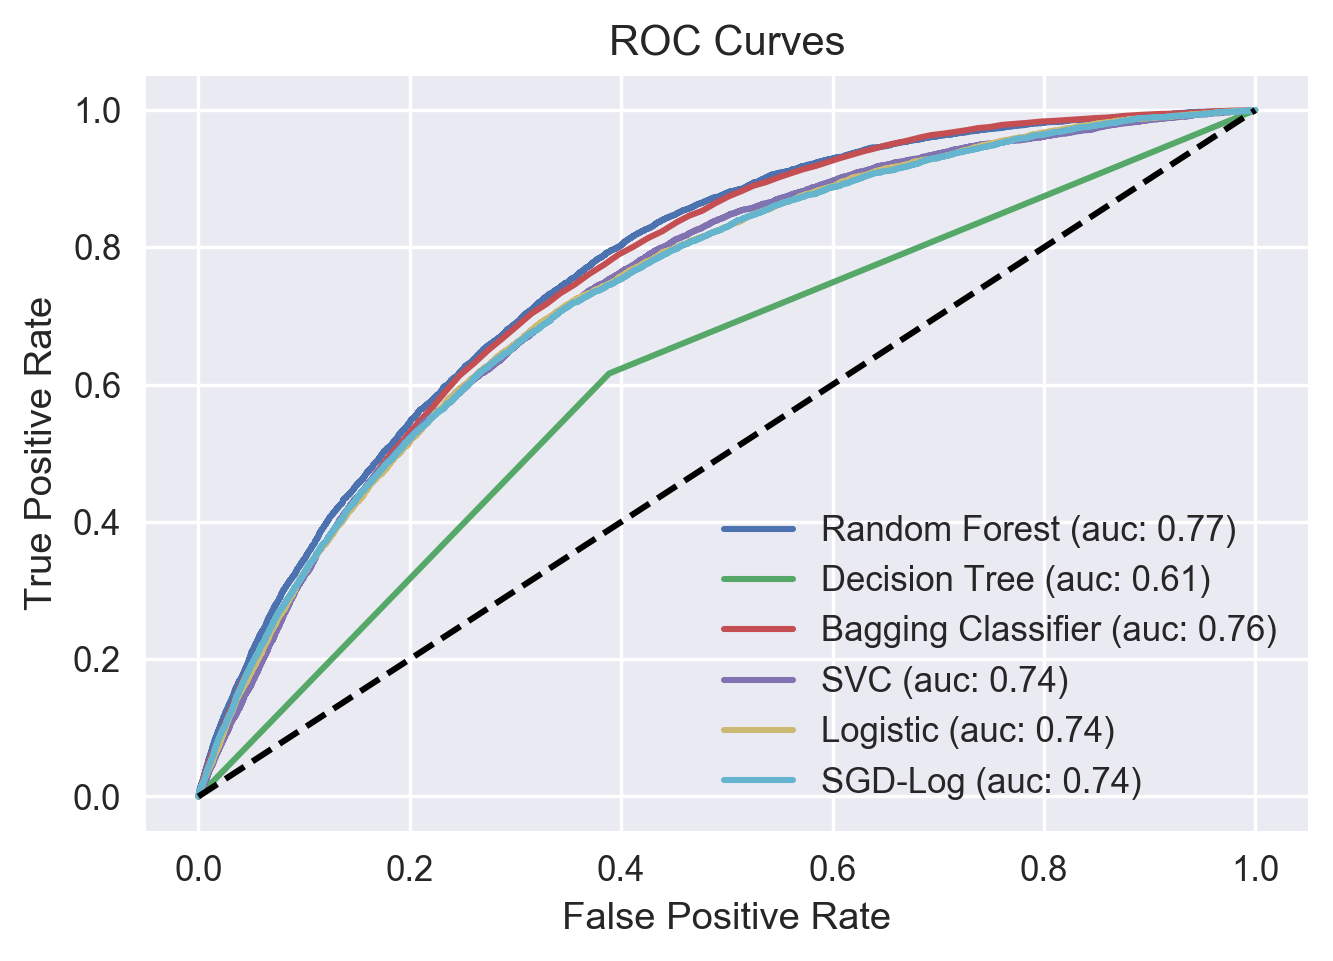

In [42]:
# Plot ROC curve for model comparison
# Noted Ramdom Forecast produces best result with an AUC of 0.77

plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.plot([0,1], [0,1], color='k', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend (loc='lower right')
plt.title('ROC Curves')

In [ ]:
rf =RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10)
rf.fit (X_train_scaled_under, y_train)

In [44]:
param_grid = {
    'n_estimators': [200,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [8,20],
    'criterion': ['gini', 'entropy']
}

SyntaxError: invalid syntax (<ipython-input-44-20772b0ff273>, line 3)

In [ ]:
rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=8)
cv.fit(X_train_scaled_under, y_train_under)